In [17]:
import numpy as np 
import pandas as pd 
import os 
import h5py
from tqdm import tqdm
import pyarrow
from datasets import load_dataset 
import torch 
import torch.nn as nn 
import time 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import torch.nn.functional as F
import sys 
sys.path.append('../code')
import utils
import model 
import loss 
import json 
import scanpy as sc

ModuleNotFoundError: No module named 'datasets'

## 保存不同数据集对应的特征信息


In [2]:
mus_gene_0 = np.load('../gene_dict/mus_gene_0.npy',allow_pickle=True)
mus_gene_1 = np.load('../gene_dict/mus_gene_1.npy',allow_pickle=True)

mus_gene_0_id = np.load('../gene_dict/mus_gene_id_0.npy',allow_pickle=True)
mus_gene_1_id = np.load('../gene_dict/mus_gene_id_1.npy',allow_pickle=True)

dataset_gene = {}

dataset_gene['mus_gene_0'] = list(mus_gene_0) 
dataset_gene['mus_gene_1'] = list(mus_gene_1) 

dataset_gene_ids = {}

dataset_gene_ids['mus_gene_0'] = list(map(int,mus_gene_0_id))
dataset_gene_ids['mus_gene_1'] = list(map(int,mus_gene_1_id))

with open('../gene_dict/dataset_gene_info.json','w') as f:
    json.dump(dataset_gene,f) 

with open('../gene_dict/dataset_gene_ids_info.json','w') as f:
    json.dump(dataset_gene_ids,f)

## 将单细胞数据转换成如下形式 

expression count, gene_ids_identifier, meta_info

In [3]:
scdata = sc.read_h5ad('personal_data/mus_brain/scdata.h5ad')

scdata

AnnData object with n_obs × n_vars = 83563 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [4]:
dict(scdata.obs.iloc[0,:])

{'batch': 'mbq'}

In [5]:
from tqdm import tqdm 
#N = scdata.shape[0]
N = 1000

if not os.path.exists('mus_brain'):
    os.makedirs('mus_brain')

gene_id_identifier = 'mus_gene_0'
data_source = 'personal_data_mus_brain_multiomics'

data_dic_list = []
#with open('mus_brain/scdata.json', 'w') as f:
for i in tqdm(range(N)):
    count = np.array(scdata.X[i,:].todense()).astype(int).reshape(-1)
    cell_id = scdata.obs.index[i]
    meta_info = dict(scdata.obs.iloc[i,:])
    meta_info['cell_id'] = cell_id 
    meta_info['source'] = data_source 

    data_dic = {'count': count, 
                     'gene_id_identifier': gene_id_identifier, 
                     'meta_info': meta_info}
    data_dic_list.append(data_dic)


100%|██████████| 1000/1000 [00:00<00:00, 4058.99it/s]


In [6]:
df = pd.DataFrame(data_dic_list)
output_file = 'mus_brain/scdata.parquet'

df.to_parquet(output_file, engine = 'pyarrow')

## 使用datasets创建dataset

In [33]:
from datasets import load_dataset 
#os.makedirs('huggingface_cache')

dataset_1 = load_dataset(path = 'mus_brain', cache_dir = 'huggingface_cache')

## 类似的处理allen_21 allen_23 数据集

In [154]:
#f = h5py.File(r"D:\sly_data\mus_brain_ref_data\CTX_Hip_counts_10x.h5",'r')

N = 1000

if not os.path.exists('allen_23'):
    os.makedirs('allen_23')

counts = np.array(scdata.X[:N,:].todense()).astype(int)
gene_id_identifier = 'mus_gene_0'
data_source = 'allen_23_mus_brain_scrna'
cell_ids = scdata.obs.index.values[:N]
cell_meta_info = scdata.obs.iloc[:N,:]

data_dic_list = []
#with open('mus_brain/scdata.json', 'w') as f:
for i in tqdm(range(N)):
    count = counts[i,:]

    meta_info = dict(cell_meta_info.iloc[i,:])
    meta_info['cell_id'] = cell_ids[i] 
    meta_info['source'] = data_source 

    data_dic = {'count': count, 
                     'gene_id_identifier': gene_id_identifier, 
                     'meta_info': meta_info}
    data_dic_list.append(data_dic)

df = pd.DataFrame(data_dic_list)
output_file = 'allen_23/scdata.parquet'

df.to_parquet(output_file, engine = 'pyarrow')

dataset_3 = load_dataset(path = 'allen_23', cache_dir = 'huggingface_cache')

100%|██████████| 1000/1000 [00:00<00:00, 11913.23it/s]
Generating train split: 1000 examples [00:01, 902.12 examples/s]


In [155]:
dataset_gene_ids.keys()

dict_keys(['mus_gene_0', 'mus_gene_1'])

In [156]:
dataset_2 = load_dataset(path = 'allen_21', cache_dir = 'huggingface_cache')
dataset_2

DatasetDict({
    train: Dataset({
        features: ['count', 'gene_id_identifier', 'meta_info'],
        num_rows: 1000
    })
})

## 创建新的tokenizer

In [295]:
class tokenizer_v1:
    def __init__(self,gene_dict, dataset_gene, dataset_gene_ids):
        self.gene_dict = gene_dict 
        self.dataset_gene = dataset_gene
        self.dataset_gene_ids = dataset_gene_ids
        #self.vocab_size = len(gene_dict)

    @property
    def vocab_size(self):
        """返回词汇表大小"""
        return len(self.gene_dict)


    def add_token(self, token, index = None):
        if index is None:
            index = self.vocab_size
        if token not in self.gene_dict:
            if index not in self.gene_dict.values():
                self.gene_dict[token] = index
            else:
                raise ValueError("index already exists")
        


    def get_token_id(self, ids, gene_id_identifier):
        # ids is a list
        return self.dataset_gene_ids[gene_id_identifier][ids]
    
    def get_token_name(self, ids, gene_id_identifier):
        return self.dataset_gene[gene_id_identifier][ids]

In [296]:
import json

# 指定json文件路径
file_path = '../gene_dict/gene_dict.json'

# 使用with语句打开文件，这样可以自动管理文件关闭
with open(file_path, 'r', encoding='utf-8') as file:
    # 使用json.load()方法加载文件内容到字典
    gene_dict = json.load(file)

for key in dataset_gene:
    dataset_gene[key] = np.array(dataset_gene[key])

for key in dataset_gene_ids:
    dataset_gene_ids[key] = np.array(dataset_gene_ids[key])

tokenizer = tokenizer_v1(gene_dict= gene_dict,
                         dataset_gene= dataset_gene,
                         dataset_gene_ids= dataset_gene_ids)


In [159]:
tokenizer.get_token_name(gene_id_identifier='mus_gene_0', ids = [1,2,3,4,5])

array(['Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17'], dtype='<U16')

In [160]:
tokenizer.get_token_id(gene_id_identifier='mus_gene_0', ids = [1,2,3,4,5])

array([12076, 12079, 15172, 27596, 29245])

## 整合三个数据集

In [161]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

    def __len__(self):
        # 返回所有数据集的总长度
        return sum(len(dataset) for dataset in self.datasets)

    def __getitem__(self, idx):
        # 找出哪个数据集包含索引 idx，并返回相应的样本
        total_len = 0
        for i, dataset in enumerate(self.datasets):
            if idx < len(dataset) + total_len:
                return self.datasets[i][idx - total_len]
            total_len += len(dataset)
        
        raise IndexError("Index out of range")

In [162]:
# 创建自定义数据集实例
combined_dataset = CustomDataset([dataset_1['train'], dataset_2['train'], dataset_3['train']])

## 创建dataloader

In [206]:
def gene_sample_1(count, max_num, rho = 0.1, pad_idx = -1):
    # sample stratege 1:
    # for cells with expressed gene num greater than max_num, random sample rho*max_num expressed gene and (1-rho)*max_num not expressed gene
    # for cells with expressed gene num less than max_num, take all expressed gene and min(max_num - L_pos, L_pos) not expressed gene 

    # the probability of non-expressed gene being sampled is zero if based on counts
    # provide a pseudo count, such that the non-expressed gene being sampled is rho  
    # we have (N_neg*\eta)/(umi_count + N*\eta) = rho 
    # then we have \eta = rho*umi_count / (N_neg - rho*N)
    

    # rho: the probability of zero-count genes being sampled, float 0-1 , default = 0.1
    # return sample ids 

    if isinstance(count, torch.Tensor) :
        count = count.numpy()
    if isinstance(count, list):
        count = np.array(count)
    umi_count = count.sum()
    N_neg = (count == 0).sum()
    N = count.shape[0]
    eta = max( (rho*umi_count) / (N_neg - rho*N) , 0) 

    sample_prob = (count + eta)/ (umi_count + N*eta)

    sample_ids = np.random.choice(np.arange(N), size = max_num, replace=False, p = sample_prob)
    return sample_ids


class collater():
    def __init__(self, tokenizer, max_expression, mask_ratio, max_num, rho, pad_idx = -1):
        self.tokenizer = tokenizer 
        self.max_num = max_num 
        self.rho = rho 
        self.pad_idx = pad_idx
        self.max_expression = max_expression
        self.mask_ratio = mask_ratio
        self.gene_cls_id = tokenizer.gene_dict['<cls>']
        self.count_mask_id = max_expression + 1 
        self.count_cls_id = max_expression + 2
        #self.mask_id = tokenizer.gene_dict['<mask>']

    def __call__(self, batch):
        batch_data = {} 

        batch_data['counts_0'] = []
        batch_data['counts_1'] = []

        batch_data['token_id_0'] = []
        batch_data['token_id_1'] = [] 

        batch_data['mask_array'] = []

        for sample in batch:
            count = np.array(sample['count'])
            gene_id_identifier = sample['gene_id_identifier'] 

            # perform down sample
            sample_ids_0 = gene_sample_1(count, max_num = self.max_num, rho = self.rho, pad_idx= self.pad_idx)
            sample_ids_1 = gene_sample_1(count, max_num = self.max_num, rho = self.rho, pad_idx= self.pad_idx)

            # encode gene_id towards number id 
            token_id_0 = tokenizer.get_token_id(ids = sample_ids_0 ,gene_id_identifier= gene_id_identifier)
            token_id_1 = tokenizer.get_token_id(ids = sample_ids_1 ,gene_id_identifier= gene_id_identifier) 

            # clip the counts 

            counts_0 = np.clip(count[sample_ids_0], a_min = 0, a_max = self.max_expression)
            counts_1 = np.clip(count[sample_ids_1], a_min = 0, a_max = self.max_expression) 

            # mask the counts 
            mask_array = np.random.choice([True, False], size= self.max_num, p=[self.mask_ratio, 1-self.mask_ratio]) 

            # add the cls token in counts and token_id

            #counts_0[mask_array] = self.count_mask_id 
            #counts_1[mask_array] = self.count_mask_id 


            token_id_0 = np.insert(token_id_0, 0, self.gene_cls_id)
            token_id_1 = np.insert(token_id_1, 0, self.gene_cls_id) 

            counts_0 = np.insert(counts_0, 0, self.count_cls_id) 
            counts_1 = np.insert(counts_1, 0, self.count_cls_id) 

            mask_array = np.insert(mask_array, 0, False) 

            # add to batch_data 
            batch_data['counts_0'].append(counts_0)
            batch_data['counts_1'].append(counts_1)
            batch_data['token_id_0'].append(token_id_0)
            batch_data['token_id_1'].append(token_id_1)
            batch_data['mask_array'].append(mask_array)


        batch_data['counts_0'] = torch.tensor(batch_data['counts_0'], dtype = torch.int)
        batch_data['counts_1'] = torch.tensor(batch_data['counts_1'], dtype = torch.int) 

        batch_data['counts_0'] = batch_data['counts_0'].long()
        batch_data['counts_1'] = batch_data['counts_1'].long()

        batch_data['token_id_0'] = torch.tensor(batch_data['token_id_0'], dtype = torch.int)
        batch_data['token_id_1'] = torch.tensor(batch_data['token_id_1'], dtype = torch.int)
        batch_data['mask_array'] = torch.tensor(batch_data['mask_array'], dtype = torch.bool) 

        counts = torch.cat((batch_data['counts_0'], batch_data['counts_1']))
        token_id = torch.cat((batch_data['token_id_0'], batch_data['token_id_1']))
        mask_array = torch.cat((batch_data['mask_array'], batch_data['mask_array'])) 
        label = counts[mask_array]
        counts[mask_array] = self.count_mask_id
        
        return (counts, token_id, mask_array, label)

In [297]:
vocab_size = tokenizer.vocab_size
print(vocab_size)

tokenizer.add_token(token = '<cls>')
#tokenizer.gene_dict['<cls>'] = vocab_size
print(tokenizer.vocab_size)
print(tokenizer.gene_dict['<cls>'])
collate_fn = collater(tokenizer= tokenizer, max_expression= 100, mask_ratio = 0.1, max_num = 6000,  rho = 0.1)

33524
33525
33524


In [298]:
from torch.utils.data import DataLoader
from tqdm import tqdm 
# 创建 DataLoader 实例
batch_size = 32
data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, collate_fn= collate_fn)

token_count = {}
for i in range(tokenizer.vocab_size + 1):
    token_count[i] = 0 
# 迭代数据
for i,batch in tqdm(enumerate(data_loader),desc = 'Processing',total =len(data_loader)):
    #counts = torch.cat((batch['counts_0'], batch['counts_1']))
    #token_id = torch.cat((batch['token_id_0'], batch['token_id_1']))
    #mask_array = torch.cat((batch['mask_array'], batch['mask_array'])) 
    counts, token_id, mask_array, label = batch
    for ele in token_id.view(-1):
        token_count[ele.item()] += 1    

Processing:   0%|          | 0/94 [00:00<?, ?it/s]C:\Users\sunrui\AppData\Local\Temp\ipykernel_11524\26062057.py:104: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  batch_data['mask_array'] = torch.tensor(batch_data['mask_array'], dtype = torch.bool)
Processing: 100%|██████████| 94/94 [04:04<00:00,  2.60s/it]


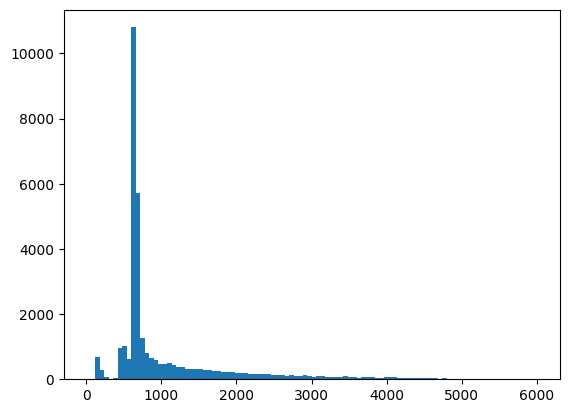

In [299]:
import matplotlib.pyplot as plt 
res = np.array(list(token_count.values()))
plt.hist(res, bins = 100)
plt.show()